In [69]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np

In [70]:
Articles=pd.read_csv('articles_cleaned.csv')

In [71]:
Articles

,title,Auteurs,pub year,author keywords,citations,DOI,abstract,document type,journal name,issn,H-index,scope,quartile,sjr,impact_factor,publisher
0,Characterizing land use-land cover changes in ...,"['Salhi, Wiam', 'Heddoun, Ouissal', 'Honnit, B...",2024,"['Deep learning', 'GIS', 'Land use-land cover'...",0,10.1007/s12518-024-00549-8,The examination of changes in land use and lan...,Article,Applied Geomatics,18669298,32.0,Applied Geomatics (AG) is the official journal...,Q2,0.536,2.43,Springer Science and Business Media Deutschlan...
1,A review & analysis of current IoT maturity & ...,"['Benotmane, Meryem', 'Elhari, Kaoutar', 'Kabb...",2023,"['Digital transformation', 'Industry 4.0', 'Io...",6,10.1016/j.sciaf.2023.e01748,Internet of Things (IoT) environments are char...,Article•,Scientific African,24682276,36.0,"ScientificAfrican is a peer reviewed, open acc...",Q1,0.575,3.347,Elsevier B.V.
2,Hybrid Deep Learning Architecture for Land Use...,"['Salhi, Wiam', 'Tabiti, Khouloud', 'Honnit, B...",2022,"['Deep learning', 'Image classification', 'Lan...",0,10.14569/IJACSA.2022.01312104,Deep Learning algorithms have become more popu...,Article•,International Journal of Advanced Computer Sci...,2158107X,47.0,Information not localizedJoin the conversation...,Q3,0.278,1.374,Science and Information Organization
3,Sentence Generation from Conceptual Graph Usin...,"['Bennani, Mohammed', 'Kabbaj, Adil']",2022,"['Conceptual graph', 'Natural language generat...",0,10.1007/978-3-030-94188-8_21,Deep learning (DL) is increasingly used in dif...,Book,Lecture Notes on Data Engineering and Communic...,23674512,30.0,The aim of the book series is to present cutti...,Q3,0.128,0.557,Springer Science and Business Media Deutschlan...
4,Survey of IoT Reference Architectures and Mode...,"['Benotmane, Meryem', 'Elhari, Kaoutar', 'Kabb...",2022,"['Digital manufacturing', 'Digital transformat...",0,10.1007/978-3-030-89906-6_21,"Nowadays, digital transformation is increasing...",Conference,Lecture Notes in Networks and Systems,23673370,36.0,The series contains proceedings and edited vol...,Q4,0.171,0.575,Springer Science and Business Media Deutschlan...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,Analysis of the visual Lombard effect and auto...,"['Heracleous, Panikos', 'Ishi, Carlos T.', 'Sa...",2013,"['Lip-reading', 'Automatic speech recognition'...",13,10.1016/j.csl.2012.06.003,<p>This study focuses on automatic visual spee...,['Article'],Computer Speech and Language,0885-2308,83,Computer Speech & Language publishes reports o...,Q1,1.05,6.103,Academic Press
5105,<i>Step-by-step</i> and <i>integrated</i> appr...,"['Meignier, S', 'Moraru, D', 'Fredouille, C', ...",2006,[],82,10.1016/j.csl.2005.08.002,<p>This paper summarizes the collaboration of ...,"['Article', 'Proceedings Paper']",Computer Speech and Language,0885-2308,83,Computer Speech & Language publishes reports o...,Q1,1.05,6.103,Academic Press
5106,Analysis and Recognition of NAM Speech Using H...,"['Heracleous, Panikos', 'Tran, Viet-Anh', 'Nag...",2010,"['Audio-visual NAM speech recognition', 'hidde...",12,10.1109/TASL.2009.2037398,<p>Non-audible murmur (NAM) is an unvoiced spe...,['Article'],"IEEE Transactions on Audio, Speech and Languag...",1558-7916,134,"Cessation. IEEE Transactions on Audio, Speech ...",Q1,0.926,0.0,Institute of Electrical and Electronics Engine...
5107,Automatic Speech Recognition for Under-Resourc...,"['Le, Viet-Bac', 'Besacier, Laurent']",2009,"['Crosslingual acoustic modeling', 'grapheme-b...",64,10.1109/TASL.2009.2021723,<p>This paper presents our work in automatic s...,['Article'],"IEEE Transactions on Audio, Speech and Languag...",1558-7916,134,"Cessation. IEEE Transactions on Audio, Speech ...",Q1,0.926,0.0,Institute of Electrical and Electronics Engine...


In [72]:
def clean_copyright(text):
    if isinstance(text, str):
        # Remove text starting with © and everything after it
        return re.sub(r'©.*$', '', text).strip()
    return text


# Apply cleaning to abstract column
Articles['abstract'] = Articles['abstract'].apply(clean_copyright)


In [73]:
Articles['abstract'] = Articles['abstract'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
Articles['title'] = Articles['title'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
Articles['journal name'] = Articles['journal name'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


c:\Users\dell\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [74]:
Articles['combined'] = Articles['title'] + ' ' + Articles['abstract']+ ' ' + Articles['author keywords']+ ' ' + Articles['journal name']

In [75]:
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))
        tokens = [token for token in tokens if token not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        # Join and clean extra whitespace
        return ' '.join(tokens).strip()
    return text


In [76]:
Articles['combined'] = Articles['combined'].apply(clean_text)

In [77]:
tfidf = TfidfVectorizer(max_features=1000)

# Appliquer la transformation TF-IDF
X = tfidf.fit_transform(Articles['combined'])

In [78]:
inertia = []  
sil_scores = []
k_range = range(2, 20) 

# Calcul des métriques pour chaque k
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X) 
    inertia.append(kmeans.inertia_) 
    sil_scores.append(silhouette_score(X, kmeans.labels_)) 


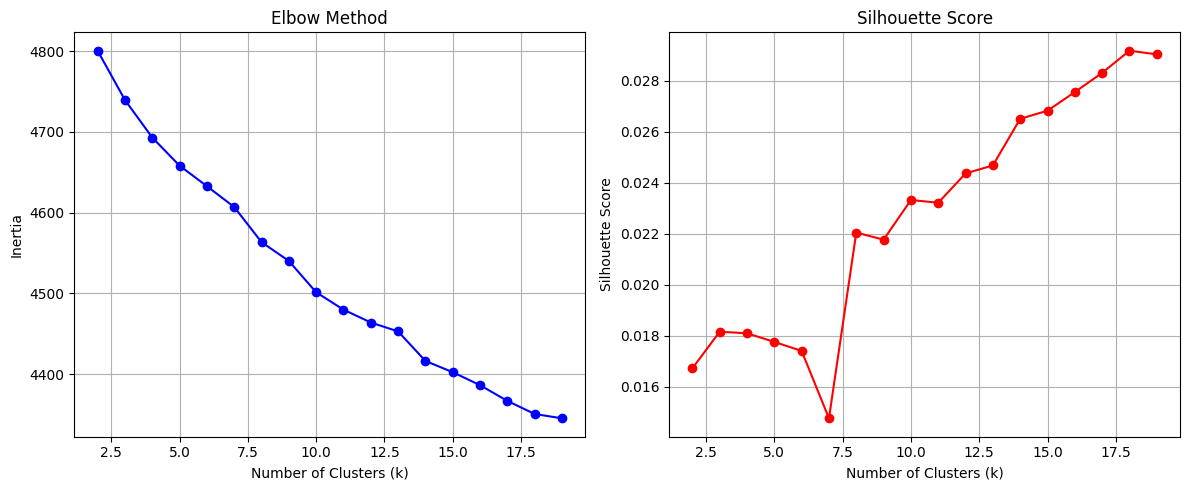

In [79]:
import matplotlib.pyplot as plt

# Create figure with 2 subplots
plt.figure(figsize=(12, 5))

# Plot Elbow Method
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [80]:
best_k = 6
kmeans = KMeans(n_clusters=best_k, init='k-means++',  random_state=42)
Articles['cluster'] = kmeans.fit_predict(X)

# Visualisation avec PCA

from sklearn.decomposition import PCA
import plotly.express as px

# Réduction de la dimensionnalité à 2D avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray()) 

# Création d'un DataFrame pour la visualisation
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = kmeans.labels_  

# Visualisation interactive avec Plotly
fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color=df_pca['cluster'].astype(str),  
    title='Clusters',
    labels={'cluster': 'Cluster'}
)
fig.show()

In [83]:
Articles[Articles['cluster'] == 1].head(10)

,title,Auteurs,pub year,author keywords,citations,DOI,abstract,document type,journal name,issn,H-index,scope,quartile,sjr,impact_factor,publisher,combined,cluster
129,An investigation of the singular perturbation ...,['Hafidi I.'],2009,[],1,No DOI,In this article we study the asymptotic behavi...,Article,Differential and Integral Equations,08934983,31.0,Differential and Integral Equations will publi...,Q2,0.79,1.8,Texas State University - San Marcos,investigation singular perturbation problem co...,1
130,Analysis of a parabolic compressible first-ord...,"['Ciuperca I.', 'Hafidi I.', 'Jai M.']",1234,"['Compressible Reynolds equation', 'Parabolic ...",1,10.1016/j.na.2006.08.054,We study a lubricated system consisting of two...,Article,"Nonlinear Analysis, Theory, Methods and Applic...",0362546X,136.0,Nonlinear Analysis aims at publishing high qua...,Q1,1.278,1.457,Elsevier Ltd,analysis parabolic compressible first order sl...,1
131,Existence of equilibria in articulated bearing...,"['Buscaglia G.', 'Ciuperca I.', 'Hafidi I.', '...",2007,"['Equilibrium', 'Lubrication', 'Reynolds varia...",4,10.1016/j.jmaa.2007.01.074,The existence of equilibrium solutions for a l...,Article,Journal of Mathematical Analysis and Applications,0022247X,162.0,The Journal of Mathematical Analysis and Appli...,Q2,0.816,1.396,Academic Press Inc.,existence equilibrium articulated bearing pres...,1
142,EXISTENCE OF SOLUTION FOR KIRCHHOFF TYPE PROBL...,"['Sbai, Abdelaaziz', 'El Hadfi, Youssef', 'Sra...",2022,"['Existence', 'Kirchhoff type problem', ""Leray...",1,10.3934/dcdss.2021015,"In this paper, we establish the existence of w...",Article•,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,existence solution kirchhoff type problem orli...,1
154,AN INVERSE PROBLEM OF IDENTIFYING TWO COEFFICI...,"['Srati, Mohammed', 'Oulmelk, Abdessamad', 'Af...",2025,"['inverse parameter problem', 'optimal control...",1,10.3934/dcdss.2023054,"In this paper, we aim to study an inverse prob...",Article,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,inverse problem identifying two coefficient ti...,1
155,IMPLEMENTATION OF THE ADMM APPROACH TO CONSTRA...,"['Oulmelk, Abdessamad', 'Srati, Mohammed', 'Af...",2025,"['ADMM method', 'convergence analysis', 'inver...",3,10.3934/dcdss.2022194,"In this paper, we study the inverse problem of...",Article,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,implementation admm approach constrained optim...,1
156,SHAPE OPTIMIZATION METHODS FOR DETECTING AN UN...,"['Afraites, Lekbir', 'Rabago, Julius Fergy T.']",2025,"['adjoint method', 'Geometric inverse problem'...",1,10.3934/dcdss.2022196,We consider the problem of identifying an unkn...,Article,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,shape optimization method detecting unknown bo...,1
157,SHAPE RECONSTRUCTION FOR ADVECTION-DIFFUSION P...,"['Cherrat, Elmehdi', 'Afraites, Lekbir', 'Raba...",2025,"['Advection-diffusion problem', 'geometric inv...",1,10.3934/dcdss.2023186,We consider the inverse problem of identifying...,Article,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,shape reconstruction advection diffusion probl...,1
158,Nonsmooth optimization method for determining ...,"['Oulmelk A.', 'Afraites L.', 'Hadri A.', 'Zak...",2025,"['Control optimal problem', 'Inverse problem',...",0,10.1016/j.cnsns.2024.108437,A determination of the nonsmooth potential par...,Article,Communications in Nonlinear Science and Numeri...,10075704,137.0,No Scope,Q1,0.919,3.864,Elsevier B.V.,nonsmooth optimization method determining nons...,1
165,Boundary shape reconstruction with Robin condi.